<a href="https://colab.research.google.com/github/Beto-cpu/Examen_AI_Lab_School_G5/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen - proyecto final
Esta evaluación consiste en resolver proyectos de inteligencia artificial considerando todo el ciclo de vida de un proyecto.

## Parte 1
Dataset: [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

### Installing and importing dependencies

In [ ]:
!pip install neptune neptune-tensorflow-keras tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow import keras
import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback
from tensorflow.keras.losses import mean_squared_error
from imblearn.over_sampling import SMOTE

In [ ]:
# Access dataset stored on Google Drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/healthcare-dataset-stroke-data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Análisis exploratorio de datos

General info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

First 5 rows
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1      

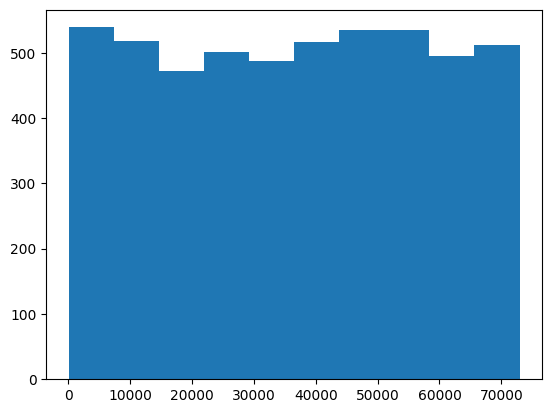


gender


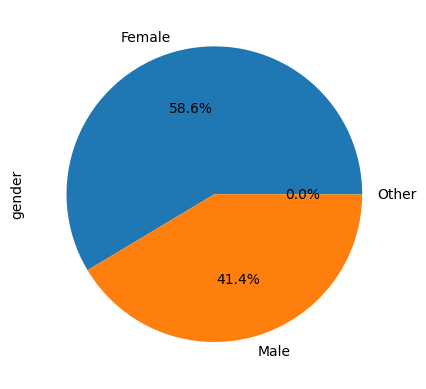


age


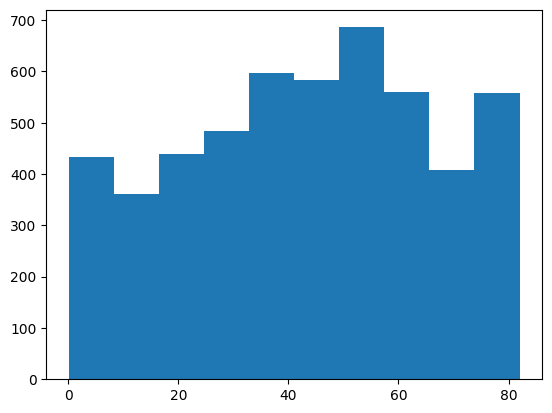


hypertension


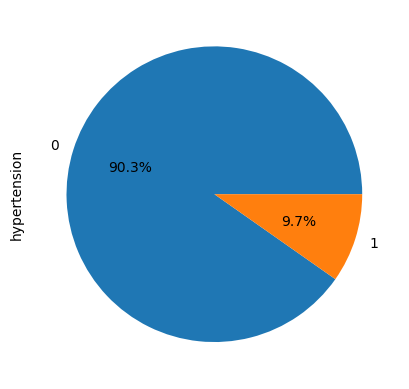


heart_disease


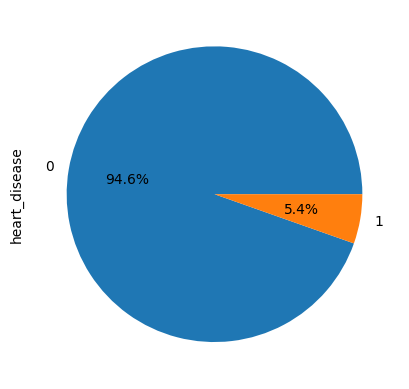


ever_married


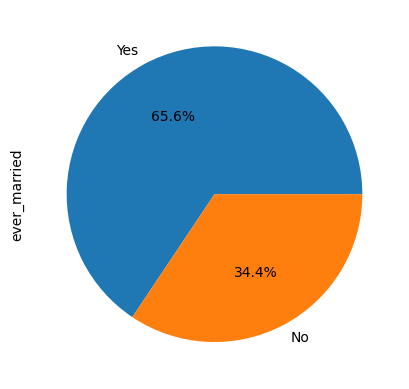


work_type


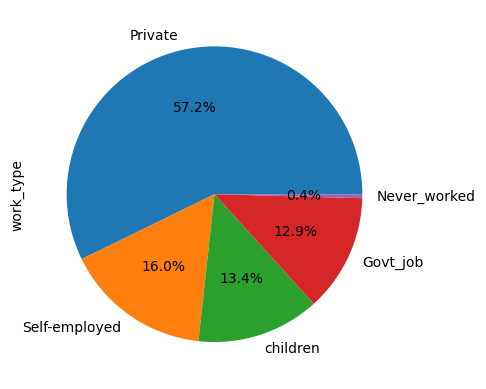


Residence_type


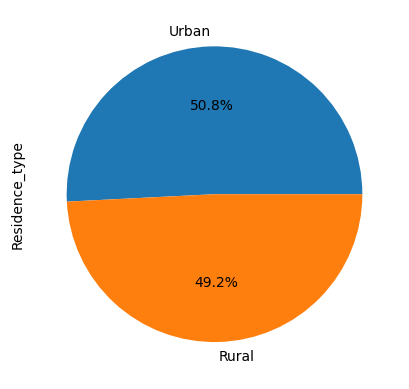


avg_glucose_level


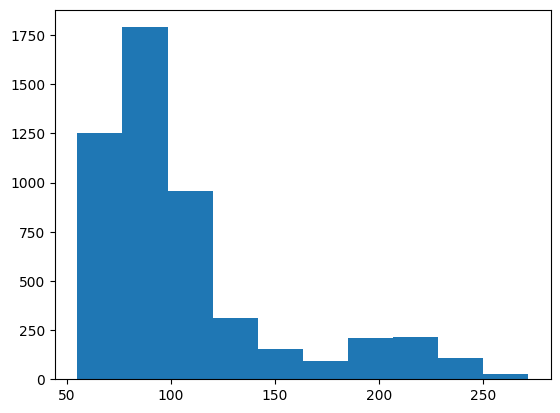


bmi


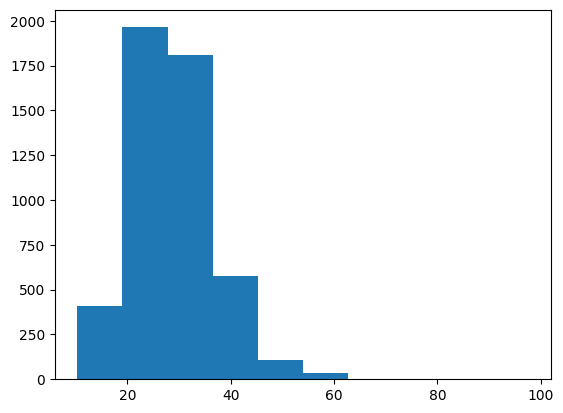


smoking_status


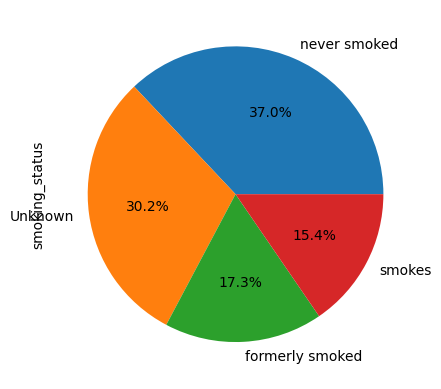


stroke


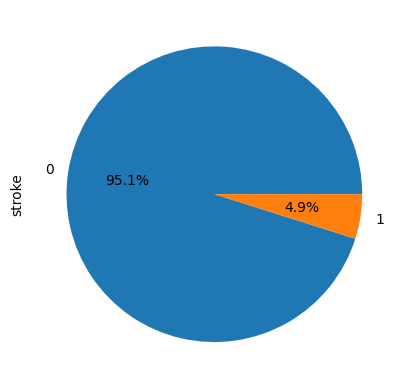

In [ ]:
# Relevant Information
print("General info")
print(df.info())

print("\nFirst 5 rows")
print(df.head(5))

print("\nNull values")
print(df.isnull().sum())


# Exploring values
for col in df.columns:
  print(f'\n{col}')
  if type(df[col][0]) == str or set(df[col]).issubset([0, 1]):
    df[col].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.show()
  else:
    plt.hist(df[col], bins=10)
    plt.show()
    # sns.countplot(x=col, data=df[col])


  

###Ingeniería / Selección de características + limpieza de datos

####Data Cleaning


Null values
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


<ipython-input-5-55fc056b1f2d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns="id", inplace=True)
<ipython-input-5-55fc056b1f2d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(how='any', inplace=True)


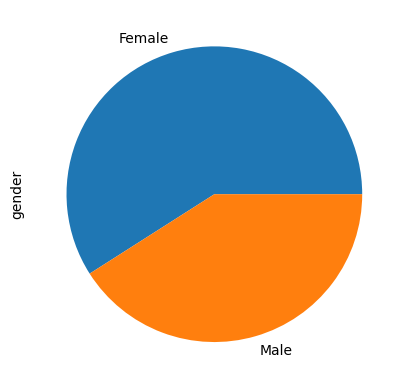

In [ ]:
# Data Cleaning
## Less than the 5% of the row are missing values so they are going to be dropped
df = df[df['gender'] != 'Other']
df.drop(columns="id", inplace=True)
df.dropna(how='any', inplace=True)

print("\nNull values")
print(df.isnull().sum())

df['gender'].value_counts().plot(kind='pie')
plt.show()

# condition = df['stroke'] == 0
# num_rows_to_drop = int(len(df[condition]) * 0.95)
# df = df.drop(df[condition].head(num_rows_to_drop).index)

In [ ]:
# Encoding Categorical Features
print("Possible boolean-based string features:")
for col in df.columns:
  if type(df[col][0]) == str and df[col].nunique() == 2:
    print(col)

encoded_df = df.copy()
encoded_df["is_male"] = encoded_df["gender"] == "Male"
encoded_df["ever_married"] = encoded_df["ever_married"] == "Yes"
encoded_df["urban_residence"] = encoded_df["Residence_type"] == "Urban"
encoded_df.drop(columns=["gender", "Residence_type"], inplace=True)

# Hot encoding
encoded_df = pd.get_dummies(encoded_df, columns=["work_type", "smoking_status"])

# Final Columns
print(f'\nFinal Columns: \n{encoded_df.columns}')


# Exploring relationships
# sns.pairplot(encoded_df)

Possible boolean-based string features:
gender
ever_married
Residence_type

Final Columns: 
Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'stroke', 'is_male', 'urban_residence',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


####Split Data

In [ ]:
x = encoded_df.drop('stroke', axis=1)
y = encoded_df['stroke']

sm = SMOTE(random_state=21)
x, y = sm.fit_resample(x, y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.1,
    random_state=21
)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=21
)



###Machine Learning Model

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression: 86.59574468085106


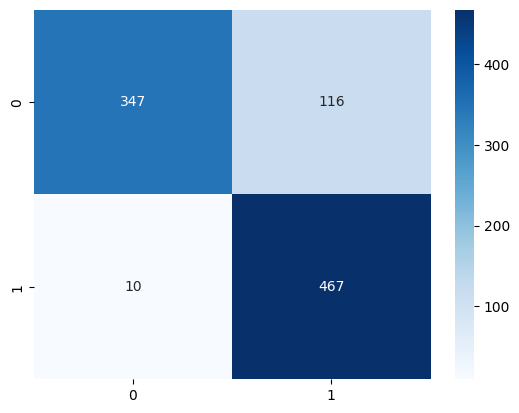


SVM: 70.0


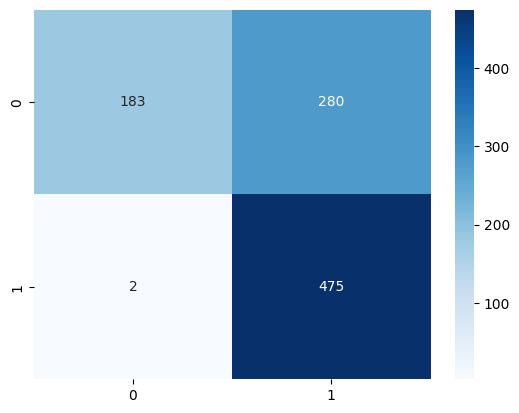


Decision Tree: 95.53191489361701


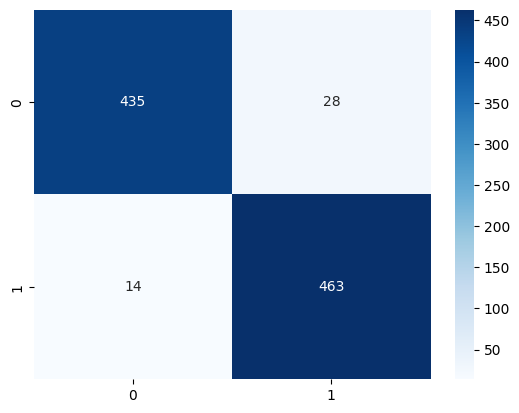


Random Forest: 91.27659574468086


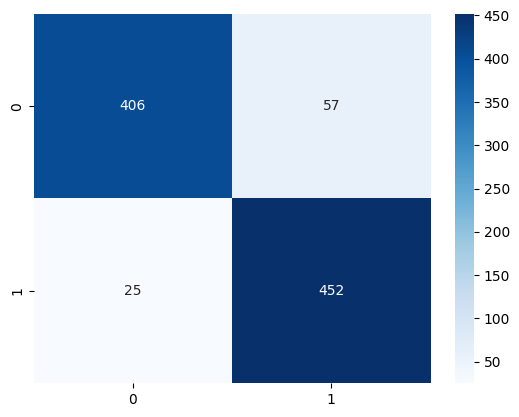

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


class_weight = {0: 1, 1: 5}
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weight, max_iter=1000),
    'SVM': SVC(class_weight=class_weight),
    'Decision Tree': DecisionTreeClassifier(class_weight=class_weight),
    'Random Forest': RandomForestClassifier(min_samples_leaf=20, min_samples_split=30, max_depth=7),
    # 'Gradient Boosting': GradientBoostingClassifier(),
    # 'Naive Bayes': GaussianNB(),
    # 'Neural Network': MLPClassifier()
}

for name, classifier in models.items():
  classifier.fit(X_train,y_train)
  lr = classifier.score(X_test,y_test) * 100
  y_pred = classifier.predict(X_test)

  # Model Results
  print(f"\n{name}: {lr}")
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
  plt.show()


###Deep Learning Model

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

7612
846
940


https://app.neptune.ai/beto-cpu/Stroke-Prediction/e/STROK-87
Epoch 1/500
238/238 [==============================] - 2s 5ms/step - loss: 0.0474 - accuracy: 0.4585 - val_loss: 0.0476 - val_accuracy: 0.3806
Epoch 2/500
238/238 [==============================] - 1s 3ms/step - loss: 0.0470 - accuracy: 0.4519 - val_loss: 0.0472 - val_accuracy: 0.3593
Epoch 3/500
238/238 [==============================] - 1s 3ms/step - loss: 0.0468 - accuracy: 0.4522 - val_loss: 0.0469 - val_accuracy: 0.4149
Epoch 4/500
238/238 [==============================] - 1s 3ms/step - loss: 0.0463 - accuracy: 0.4708 - val_loss: 0.0466 - val_accuracy: 0.4929
Epoch 5/500
238/238 [==============================] - 1s 5ms/step - loss: 0.0462 - accuracy: 0.4706 - val_loss: 0.0463 - val_accuracy: 0.4953
Epoch 6/500
238/238 [==============================] - 1s 3ms/step - loss: 0.0460 - accuracy: 0.4796 - val_loss: 0.0462 - val_accuracy: 0.4905
Epoch 7/500
238/238 [==============================] - 1s 3ms/step - loss: 0.0458

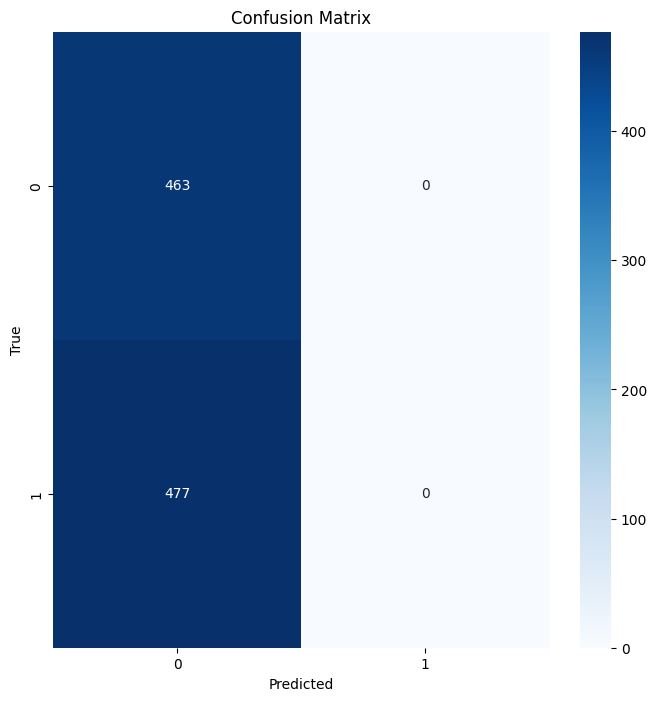

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/beto-cpu/Stroke-Prediction/e/STROK-87/metadata


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

if hasattr(X_train, 'values'):
  X_train = X_train.values.astype(np.float32)
if hasattr(y_train, 'values'):
  y_train = y_train.values.astype(np.float32)
if hasattr(X_val, 'values'):
  X_val = X_val.values.astype(np.float32)
if hasattr(y_val, 'values'):
  y_val = y_val.values.astype(np.float32)
if hasattr(X_test, 'astype'):
  X_test = X_test.astype(np.float32)  
  X_test = tf.convert_to_tensor(X_test)
if hasattr(y_test, 'astype'):
  y_test = y_test.astype(np.float32)  
  y_test = tf.convert_to_tensor(y_test)

# Connect with Neptune Project 
run = neptune.init_run(
    project="beto-cpu/Stroke-Prediction",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1MzkxYWIyOC00YjNlLTQwMDYtOTc4Yi1kODJjY2VjYmFkNDIifQ==",
)

params = {"lr": 0.0005, "momentum": 0.1, "label_smoothing": 0.01, "epochs": 500, "dropout": 0.05}
run["parameters"] = params

model = keras.models.Sequential([
    keras.layers.Dense(32, input_shape=(17,), activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(params["dropout"]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(params["dropout"]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(params["dropout"]),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(params["dropout"]),
    keras.layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.SGD(
    learning_rate=params["lr"],
    momentum=params["momentum"],
)


def weighted_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    # Compute binary cross-entropy loss
    bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)

    # Calculate class weights
    count_0 = tf.reduce_sum(1 - y_true)
    count_1 = tf.reduce_sum(y_true)
    weight_for_0 = 1 / count_0
    weight_for_1 = 1 / count_1

    # Apply weights to the loss
    weights = tf.where(y_true == 1, weight_for_1, weight_for_0)
    weighted_bce = tf.reduce_mean(tf.multiply(weights, bce))

    return weighted_bce
early_stopper = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy, metrics=["accuracy"])

neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

model.fit(
    X_train,
    y_train,
    epochs=params["epochs"],
    callbacks=[neptune_cbk, early_stopper],
    validation_data=(X_val, y_val)
)

# Save Metrics
eval_metrics = model.evaluate(X_test, y_test, verbose=0)
for j, metric in enumerate(eval_metrics):
    run["eval/{}".format(model.metrics_names[j])] = metric

# Compute confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix and save to Neptune
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

run.stop()